## Import Statements

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


## Read in Data

In [10]:
df = pd.read_csv('data/preprocessed_repair_data.csv')
df = df[df['Label'] == 1];
df.drop(columns=['Label', 'Distance', 'Months', 'Odometer'], inplace=True)
df.head()

,TaskName,Make,Model,Year,FuelType,EngineSize,Transmission,DriveType,IsHybrid,AdjustedPrice
0,Park Light Globe Replacement,HYUNDAI,HYUNDAI TUCSON,2019,Diesel,2.0,Auto,4WD,0.0,7.0
1,Roadworthy Inspection / Pink Slips,VOLKSWAGEN,VOLKSWAGEN TIGUAN,2018,Petrol,2.0,Auto,4WD,0.0,46.0
2,Replace Wiper Blades,VOLKSWAGEN,VOLKSWAGEN TIGUAN,2018,Petrol,2.0,Auto,4WD,0.0,29.0
3,Rear Brake Pad And Rotor Replacement,VOLKSWAGEN,VOLKSWAGEN TIGUAN,2018,Petrol,2.0,Auto,4WD,0.0,725.0
5,Replace Wiper Blades,KIA,KIA SELTOS,2020,Petrol,1.6,Auto,4WD,0.0,46.0


In [11]:
X = df.drop(columns=["AdjustedPrice"])  
y = df["AdjustedPrice"]       

cat_feature_indices = [0, 1, 2, 4, 6, 7]

In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

In [13]:
for col in X_train.select_dtypes(include='object').columns:
     X_train[col] = X_train[col].fillna("missing")

for col in X_val.select_dtypes(include='object').columns:
   X_val[col] = X_val[col].fillna("missing")

for col in X_test.select_dtypes(include='object').columns:
   X_test[col] = X_test[col].fillna("missing")

In [14]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    nonzero_mask = y_true != 0
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

In [15]:
model = CatBoostRegressor(
    eval_metric='MAPE',
    loss_function='RMSEWithUncertainty',
    od_type='Iter',
    od_wait=50,
    random_seed=42,
    verbose=0,
    thread_count=4
)

param_grid = {
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7],
    'iterations': [1000, 1500],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bylevel': [0.8, 0.9, 1.0],
    'min_child_samples': [5, 10, 20],
}


random_search = RandomizedSearchCV(
    model,
    param_distributions=param_grid,
    n_iter=25,            
    cv=3,                 
    scoring='neg_mean_absolute_percentage_error',
    random_state=42,
    verbose=2,
    n_jobs=-1
)

In [16]:
random_search.fit(
    X_train, y_train,
    cat_features=cat_feature_indices,
    early_stopping_rounds=200
)

print("Best params:", random_search.best_params_)
print("Best CV score (MAPE):", -random_search.best_score_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END colsample_bylevel=0.9, depth=8, iterations=1000, l2_leaf_reg=7, learning_rate=0.1, min_child_samples=20, subsample=0.9; total time= 9.7min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=8, iterations=1000, l2_leaf_reg=7, learning_rate=0.1, min_child_samples=20, subsample=0.9; total time= 9.9min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=6, iterations=1500, l2_leaf_reg=7, learning_rate=0.03, min_child_samples=10, subsample=1.0; total time=10.1min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=6, iterations=1500, l2_leaf_reg=5, learning_rate=0.03, min_child_samples=20, subsample=0.8; total time=10.1min
[CV] END colsample_bylevel=0.9, depth=6, iterations=1500, l2_leaf_reg=5, learning_rate=0.03, min_child_samples=20, subsample=0.8; total time=10.2min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=6, iterations=1500, l2_leaf_reg=7, learning_rate=0.03, min_child_samples=10, subsample=1.0; total time=10.2min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=8, iterations=1000, l2_leaf_reg=7, learning_rate=0.1, min_child_samples=20, subsample=0.9; total time=10.2min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=6, iterations=1500, l2_leaf_reg=7, learning_rate=0.03, min_child_samples=10, subsample=1.0; total time=10.3min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=6, iterations=1500, l2_leaf_reg=5, learning_rate=0.03, min_child_samples=20, subsample=0.8; total time=10.7min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=8, iterations=1500, l2_leaf_reg=1, learning_rate=0.03, min_child_samples=5, subsample=0.8; total time=15.7min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=8, iterations=1000, l2_leaf_reg=5, learning_rate=0.03, min_child_samples=10, subsample=1.0; total time= 9.6min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=8, iterations=1000, l2_leaf_reg=5, learning_rate=0.03, min_child_samples=10, subsample=1.0; total time= 9.7min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.01, min_child_samples=20, subsample=0.8; total time= 9.2min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=8, iterations=1000, l2_leaf_reg=5, learning_rate=0.03, min_child_samples=10, subsample=1.0; total time= 9.7min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=10, iterations=1500, l2_leaf_reg=7, learning_rate=0.1, min_child_samples=10, subsample=1.0; total time=22.2min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=10, iterations=1500, l2_leaf_reg=7, learning_rate=0.1, min_child_samples=10, subsample=1.0; total time=22.2min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=10, iterations=1500, l2_leaf_reg=7, learning_rate=0.1, min_child_samples=10, subsample=1.0; total time=22.4min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=10, iterations=1500, l2_leaf_reg=3, learning_rate=0.05, min_child_samples=5, subsample=0.8; total time=22.5min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=10, iterations=1500, l2_leaf_reg=3, learning_rate=0.05, min_child_samples=5, subsample=0.8; total time=22.8min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=10, iterations=1500, l2_leaf_reg=3, learning_rate=0.05, min_child_samples=5, subsample=0.8; total time=22.8min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.01, min_child_samples=20, subsample=0.8; total time= 9.3min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=8, iterations=1500, l2_leaf_reg=1, learning_rate=0.03, min_child_samples=5, subsample=0.8; total time=15.5min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=8, iterations=1500, l2_leaf_reg=1, learning_rate=0.03, min_child_samples=5, subsample=0.8; total time=15.5min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=8, iterations=1500, l2_leaf_reg=1, learning_rate=0.1, min_child_samples=20, subsample=0.9; total time=15.7min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=8, iterations=1500, l2_leaf_reg=1, learning_rate=0.1, min_child_samples=20, subsample=0.9; total time=15.9min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=8, iterations=1500, l2_leaf_reg=1, learning_rate=0.1, min_child_samples=20, subsample=0.9; total time=15.9min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.01, min_child_samples=20, subsample=0.8; total time= 9.8min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=6, iterations=1000, l2_leaf_reg=7, learning_rate=0.05, min_child_samples=10, subsample=0.9; total time= 7.8min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=6, iterations=1000, l2_leaf_reg=7, learning_rate=0.05, min_child_samples=10, subsample=0.9; total time= 8.1min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=6, iterations=1000, l2_leaf_reg=7, learning_rate=0.05, min_child_samples=10, subsample=0.9; total time= 8.4min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=8, iterations=1000, l2_leaf_reg=7, learning_rate=0.03, min_child_samples=5, subsample=1.0; total time=10.9min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=8, iterations=1000, l2_leaf_reg=7, learning_rate=0.03, min_child_samples=5, subsample=1.0; total time=11.9min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=8, iterations=1000, l2_leaf_reg=7, learning_rate=0.03, min_child_samples=5, subsample=1.0; total time=12.7min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=10, iterations=1000, l2_leaf_reg=3, learning_rate=0.01, min_child_samples=20, subsample=0.8; total time=18.1min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=10, iterations=1000, l2_leaf_reg=3, learning_rate=0.01, min_child_samples=20, subsample=0.8; total time=18.2min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=10, iterations=1000, l2_leaf_reg=3, learning_rate=0.01, min_child_samples=20, subsample=0.8; total time=18.3min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=10, iterations=1000, l2_leaf_reg=5, learning_rate=0.03, min_child_samples=20, subsample=0.8; total time=25.7min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=10, iterations=1000, l2_leaf_reg=5, learning_rate=0.01, min_child_samples=10, subsample=0.8; total time=25.1min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=10, iterations=1000, l2_leaf_reg=5, learning_rate=0.01, min_child_samples=10, subsample=0.8; total time=24.2min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=10, iterations=1000, l2_leaf_reg=5, learning_rate=0.03, min_child_samples=20, subsample=0.8; total time=28.3min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.1, min_child_samples=5, subsample=0.8; total time=19.7min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=10, iterations=1000, l2_leaf_reg=5, learning_rate=0.03, min_child_samples=20, subsample=0.8; total time=28.2min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=10, iterations=1000, l2_leaf_reg=5, learning_rate=0.01, min_child_samples=10, subsample=0.8; total time=25.0min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=10, iterations=1000, l2_leaf_reg=7, learning_rate=0.05, min_child_samples=10, subsample=0.8; total time=28.2min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=10, iterations=1500, l2_leaf_reg=3, learning_rate=0.03, min_child_samples=10, subsample=0.9; total time=39.3min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=10, iterations=1000, l2_leaf_reg=7, learning_rate=0.05, min_child_samples=10, subsample=0.8; total time=27.3min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=10, iterations=1500, l2_leaf_reg=3, learning_rate=0.03, min_child_samples=10, subsample=0.9; total time=39.9min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=10, iterations=1000, l2_leaf_reg=7, learning_rate=0.05, min_child_samples=10, subsample=0.8; total time=28.1min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=10, iterations=1500, l2_leaf_reg=3, learning_rate=0.03, min_child_samples=10, subsample=0.9; total time=40.3min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=10, iterations=1500, l2_leaf_reg=5, learning_rate=0.1, min_child_samples=5, subsample=1.0; total time=43.2min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=10, iterations=1500, l2_leaf_reg=5, learning_rate=0.1, min_child_samples=5, subsample=1.0; total time=43.1min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=10, iterations=1500, l2_leaf_reg=5, learning_rate=0.1, min_child_samples=5, subsample=1.0; total time=43.2min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=6, iterations=1000, l2_leaf_reg=5, learning_rate=0.05, min_child_samples=5, subsample=0.9; total time=12.8min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=6, iterations=1000, l2_leaf_reg=5, learning_rate=0.05, min_child_samples=5, subsample=0.9; total time=13.7min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=6, iterations=1000, l2_leaf_reg=5, learning_rate=0.05, min_child_samples=5, subsample=0.9; total time=13.3min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.1, min_child_samples=5, subsample=0.8; total time=18.8min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.1, min_child_samples=5, subsample=0.8; total time=19.2min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.05, min_child_samples=10, subsample=0.8; total time=13.9min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.05, min_child_samples=10, subsample=0.8; total time=13.5min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.05, min_child_samples=10, subsample=0.8; total time=13.3min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=8, iterations=1000, l2_leaf_reg=1, learning_rate=0.1, min_child_samples=10, subsample=1.0; total time=19.6min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=8, iterations=1000, l2_leaf_reg=1, learning_rate=0.1, min_child_samples=10, subsample=1.0; total time=19.6min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=8, iterations=1000, l2_leaf_reg=1, learning_rate=0.1, min_child_samples=10, subsample=1.0; total time=19.3min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=10, iterations=1000, l2_leaf_reg=1, learning_rate=0.05, min_child_samples=5, subsample=1.0; total time=28.9min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=10, iterations=1000, l2_leaf_reg=1, learning_rate=0.05, min_child_samples=5, subsample=1.0; total time=29.4min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=8, iterations=1500, l2_leaf_reg=1, learning_rate=0.1, min_child_samples=5, subsample=0.8; total time=23.4min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=8, iterations=1500, l2_leaf_reg=1, learning_rate=0.1, min_child_samples=5, subsample=0.8; total time=23.6min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=10, iterations=1000, l2_leaf_reg=1, learning_rate=0.05, min_child_samples=5, subsample=1.0; total time=26.6min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=8, iterations=1500, l2_leaf_reg=1, learning_rate=0.1, min_child_samples=5, subsample=0.8; total time=22.2min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=8, iterations=1500, l2_leaf_reg=7, learning_rate=0.1, min_child_samples=10, subsample=1.0; total time=19.5min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=8, iterations=1500, l2_leaf_reg=7, learning_rate=0.1, min_child_samples=10, subsample=1.0; total time=19.8min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=8, iterations=1500, l2_leaf_reg=7, learning_rate=0.1, min_child_samples=10, subsample=1.0; total time=16.4min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=10, iterations=1500, l2_leaf_reg=1, learning_rate=0.1, min_child_samples=5, subsample=0.8; total time=17.2min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=10, iterations=1500, l2_leaf_reg=1, learning_rate=0.1, min_child_samples=5, subsample=0.8; total time=11.4min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=10, iterations=1500, l2_leaf_reg=1, learning_rate=0.1, min_child_samples=5, subsample=0.8; total time=11.4min
Best params: {'subsample': 1.0, 'min_child_samples': 10, 'learning_rate': 0.1, 'l2_leaf_reg': 7, 'iterations': 1500, 'depth': 10, 'colsample_bylevel': 0.8}
Best CV score (MAPE): nan


In [17]:
best_params = random_search.best_params_

best_model = CatBoostRegressor(
    **best_params,
    cat_features=cat_feature_indices,
    eval_metric='MAPE',
    random_seed=42,
    verbose=100
)

best_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    use_best_model=True,
    early_stopping_rounds=200
)


0:	learn: 2.8276671	test: 2.8111416	best: 2.8111416 (0)	total: 78.6ms	remaining: 1m 57s
100:	learn: 0.8582503	test: 0.7867821	best: 0.7867821 (100)	total: 4.65s	remaining: 1m 4s
200:	learn: 0.8401748	test: 0.7748085	best: 0.7747633 (199)	total: 9.9s	remaining: 1m 3s
300:	learn: 0.8270388	test: 0.7684103	best: 0.7682559 (299)	total: 15.7s	remaining: 1m 2s
400:	learn: 0.8188339	test: 0.7635632	best: 0.7635632 (400)	total: 21.6s	remaining: 59.2s
500:	learn: 0.8125020	test: 0.7623897	best: 0.7620267 (499)	total: 27.4s	remaining: 54.7s
600:	learn: 0.8075785	test: 0.7628710	best: 0.7613204 (553)	total: 33.2s	remaining: 49.7s
700:	learn: 0.7958293	test: 0.7564808	best: 0.7564808 (700)	total: 38.9s	remaining: 44.4s
800:	learn: 0.7904401	test: 0.7541990	best: 0.7536843 (793)	total: 44.2s	remaining: 38.6s
900:	learn: 0.7865051	test: 0.7537353	best: 0.7535983 (899)	total: 49.9s	remaining: 33.2s
1000:	learn: 0.7818094	test: 0.7541402	best: 0.7533834 (945)	total: 55.6s	remaining: 27.7s
1100:	learn:

In [20]:
y_pred = best_model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape:.2f}%")

MAE: 155.13289343871145
RMSE: 501.8763883100623
MAPE: 74.13%


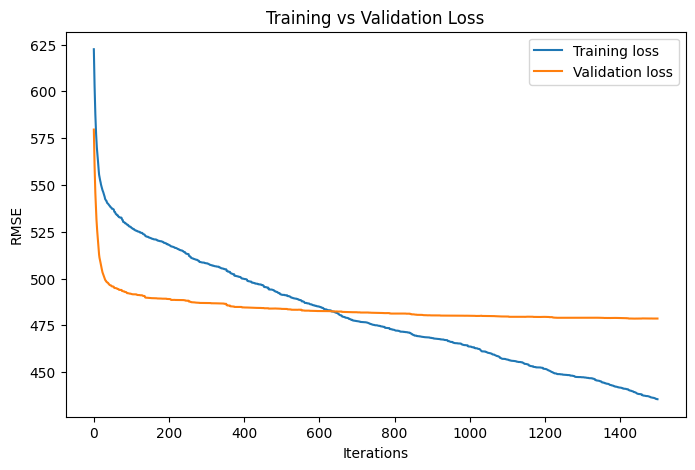

In [21]:
evals_result = best_model.get_evals_result()

# Plot loss curves
plt.figure(figsize=(8,5))
plt.plot(evals_result['learn']['RMSE'], label='Training loss')
plt.plot(evals_result['validation']['RMSE'], label='Validation loss')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

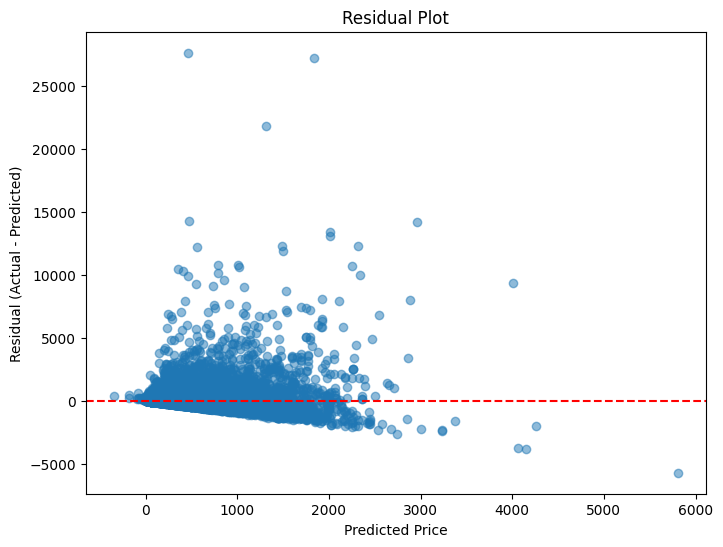

In [22]:
residuals = y_test - y_pred
plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()

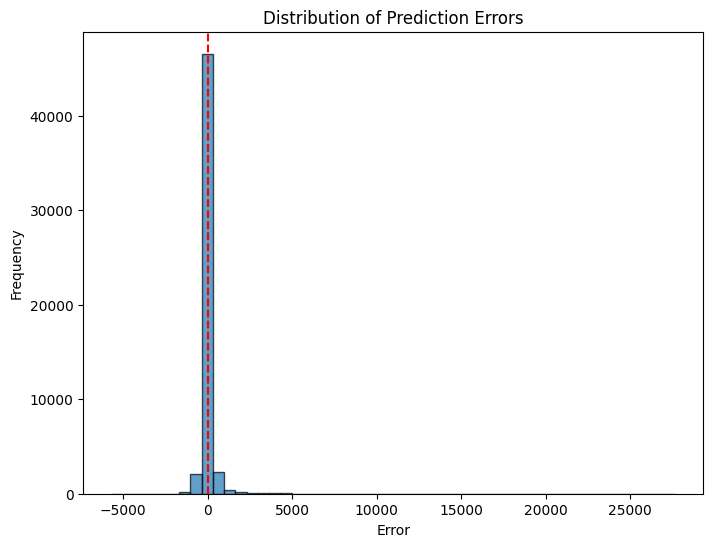

In [23]:
plt.figure(figsize=(8,6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()

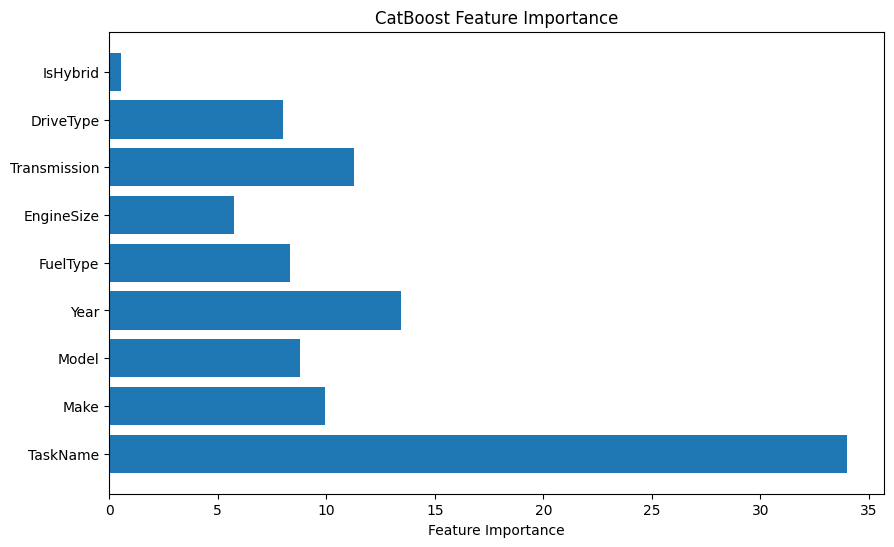

In [24]:
importance = best_model.get_feature_importance()
feature_names = X_train.columns  # or your list of feature names

plt.figure(figsize=(10,6))
plt.barh(feature_names, importance)
plt.xlabel('Feature Importance')
plt.title('CatBoost Feature Importance')
plt.show()

/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


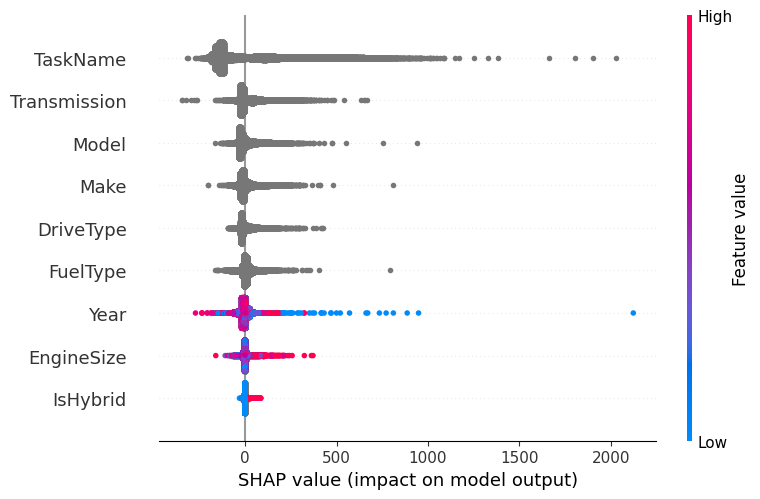

In [25]:
import shap

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

In [26]:
best_model.save_model('models/repair_model.cbm')